# 時系列解析入門

# **2. 時系列データの前処理 (45分)**

# <font color="DarkOrange">1. 時系列データを解析するための前処理手法</font>


## <font color="SeaGreen">1-a 欠損値の処理</font>
時系列データには観測のミスやデータ収集の欠如などにより、欠損値が含まれることがあります。これを適切に補間することは、データ解析の精度を高める上で重要です。ここでは、主な欠損値補間の手法を解説します。

**利用データ**<br>
以下はKaggleで公開されているAir Passengers Datasetです。具体的には、1949年から1960年までの月毎の飛行機乗客数のデータです。今回はあえて1954年1月から1954年6月のデータを欠損させたデータ（グラフの緑色の部分）にしています。まずはデータを読み込んで可視化してみます。



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-2-1b10f26a53d6>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(


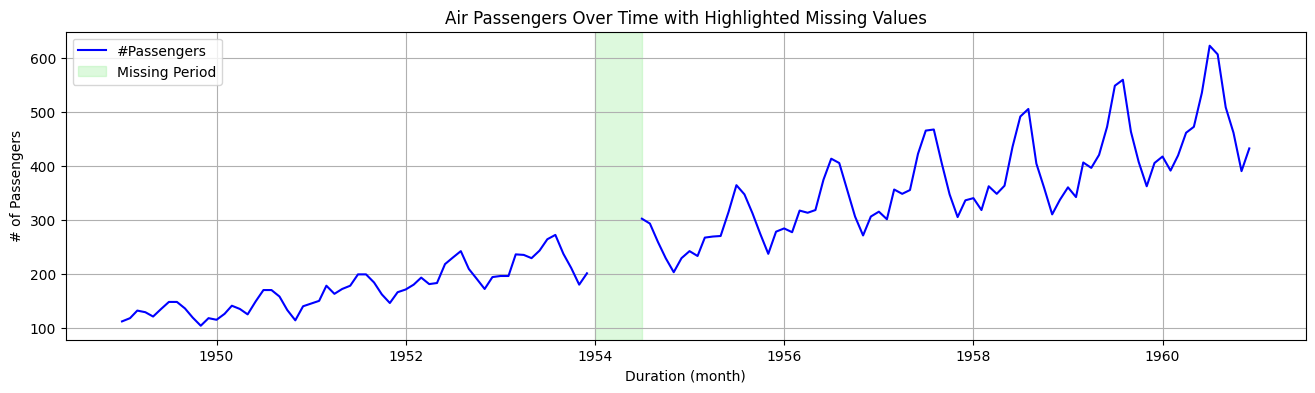

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 欠損値を含むAir Passengers Dataset読み込み
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(
    '/content/drive/MyDrive/time_series/seminar/files/AirPassengers_loss.csv',
    index_col='Month',
    date_parser=dateparse,
    dtype={'#Passengers': 'float'}  # 欠損値を許容するため float を指定
)

# プロット
plt.figure(figsize=(16, 4))
plt.plot(data.index, data['#Passengers'], label='#Passengers', color='blue')

# 欠損期間を特定して色付け
start_missing = datetime(1954, 1, 1)  # 欠損開始
end_missing = datetime(1954, 6, 30)  # 欠損終了
plt.axvspan(start_missing, end_missing, color='LightGreen', alpha=0.3, label='Missing Period')

# グラフの設定
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
plt.title('Air Passengers Over Time with Highlighted Missing Values')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# 1954年1月から6月までの値を抽出
start_date = '1954-01'
end_date = '1954-06'

filtered_data = data.loc[start_date:end_date]

# 値を表示
print(filtered_data)


            #Passengers
Month                  
1954-01-01          NaN
1954-02-01          NaN
1954-03-01          NaN
1954-04-01          NaN
1954-05-01          NaN
1954-06-01          NaN


1954年1月から1954年6月までの値が欠損していることが確認できます。
ではこの欠損している部分を補間してみます。

補間法には様々な手法がありますが、ここでは、線形補間法、移動平均補間法、スプライン補間法、カルマン平滑化補間法をご紹介します。

まず、基本的な線形補間法や移動平均補間法を試し、データの特性に応じてスプライン補間法やカルマン平滑化補間法を検討することをお勧めします。

### <u>線形補間法</u>
**概要**<br>
- 欠損値の両端の既知のデータ点を結ぶ直線を用いて値を補間します。
- シンプルで計算コストが低いため、基本的な方法として広く使われています。

**特徴**<br>
- 単純で実装が容易です。
- 直線的な傾向が強いデータに適しています。

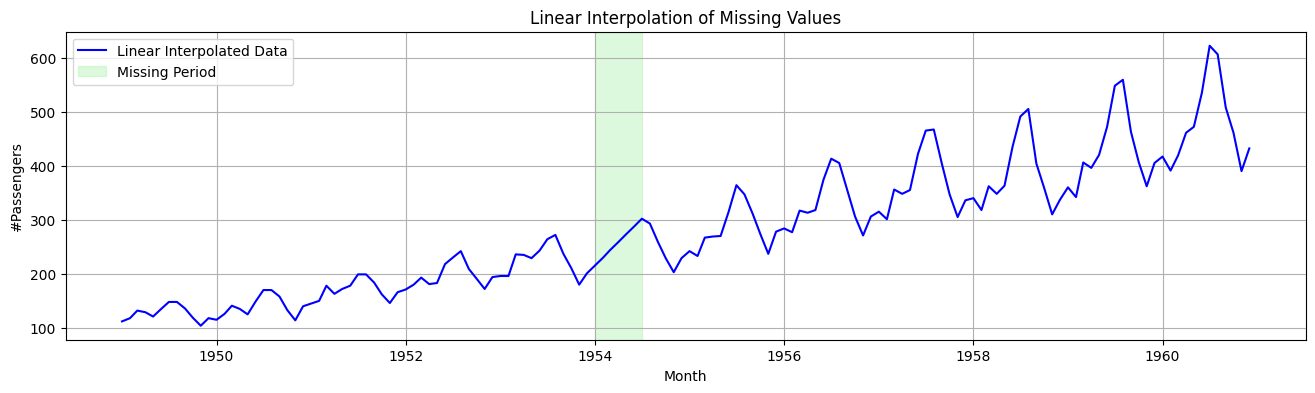

In [4]:
# 線形補間法の適用
linear_interpolated_data = data.copy()
linear_interpolated_data['#Passengers'] = data['#Passengers'].interpolate(method='linear')

# プロット
plt.figure(figsize=(16, 4))
plt.plot(linear_interpolated_data.index, linear_interpolated_data['#Passengers'], label='Linear Interpolated Data', color='blue')

# 欠損期間を色付け（1954年1月から6月）
plt.axvspan(start_missing, end_missing, color='LightGreen', alpha=0.3, label='Missing Period')

# グラフの詳細設定
plt.title('Linear Interpolation of Missing Values')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.legend()
plt.grid(True)
plt.show()


### <u>移動平均補間法</u>
**概要**<br>
- 欠損値の前後のデータ点の平均値を計算して補間します。
- 短期的な変動を平滑化する効果もあります。

**特徴**<br>
- ノイズが多いデータに有効です。
- 過去や未来の値を使うため、データの全体的な傾向を保ちます。

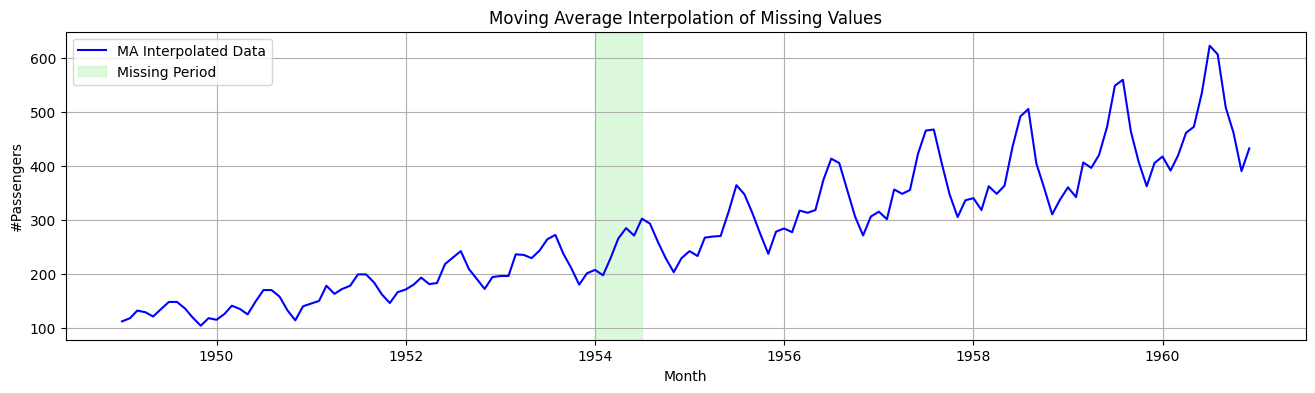

In [5]:
# 移動平均補間の適用
ma_interpolated_data = data.copy()
ma_interpolated_data['#Passengers'] = data['#Passengers'].fillna(data['#Passengers'].rolling(window=9, min_periods=1, center=True).mean())

# プロット
plt.figure(figsize=(16, 4))
plt.plot(ma_interpolated_data.index, ma_interpolated_data['#Passengers'], label='MA Interpolated Data', color='blue')

# 欠損期間を色付け（例: 1954年1月から6月を色付け）
plt.axvspan(start_missing, end_missing, color='LightGreen', alpha=0.3, label='Missing Period')

# グラフの詳細設定
plt.title('Moving Average Interpolation of Missing Values')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.legend()
plt.grid(True)
plt.show()


### <u>スプライン補間法</u>
**概要**<br>
- 欠損値を滑らかな曲線（スプライン）で補間します。
- データの形状やトレンドを反映するため、非線形のパターンにも対応できます。

**特徴**<br>
- データのトレンドが滑らかな場合に適しています。
- 線形補間よりも精度が高いです。

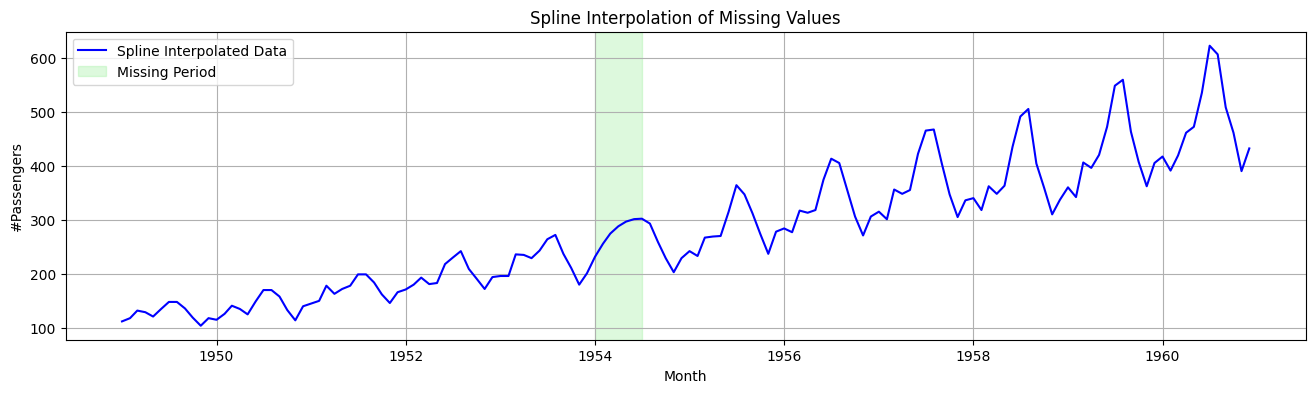

In [6]:
from scipy.interpolate import UnivariateSpline

# スプライン補間法の適用
spline_interpolated_data = data.copy()

# 有効なデータポイント（欠損値ではない箇所）を取得
valid_indices = np.arange(len(data))  # データのインデックス（数値）
valid_points = valid_indices[~data['#Passengers'].isnull()]  # 欠損値以外のインデックス
valid_values = data['#Passengers'][~data['#Passengers'].isnull()]  # 欠損値以外の値

# スプライン補間
spline = UnivariateSpline(valid_points, valid_values, s=0)  # 平滑化パラメータ s=0
spline_interpolated_data['#Passengers'] = spline(valid_indices)

# プロット
plt.figure(figsize=(16, 4))
plt.plot(spline_interpolated_data.index, spline_interpolated_data['#Passengers'], label='Spline Interpolated Data', color='blue')

# 欠損期間を色付け（例: 1954年1月から6月を色付け）
plt.axvspan(start_missing, end_missing, color='LightGreen', alpha=0.3, label='Missing Period')

# グラフの詳細設定
plt.title('Spline Interpolation of Missing Values')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.legend()
plt.grid(True)
plt.show()


### <u>カルマン平滑化補間法</u>
**概要**<br>
- 状態空間モデルを用い、観測データとモデルの予測を融合して欠損値を補間します。
- 最適な推定値を得るために、動的モデルを使用します。

**特徴**<br>
- 最も複雑な方法ですが精度が高いです。
- 雑音の多い時系列データや非線形の傾向に対して非常に有効です。

In [7]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 12.6 MB/s eta 0:00:00


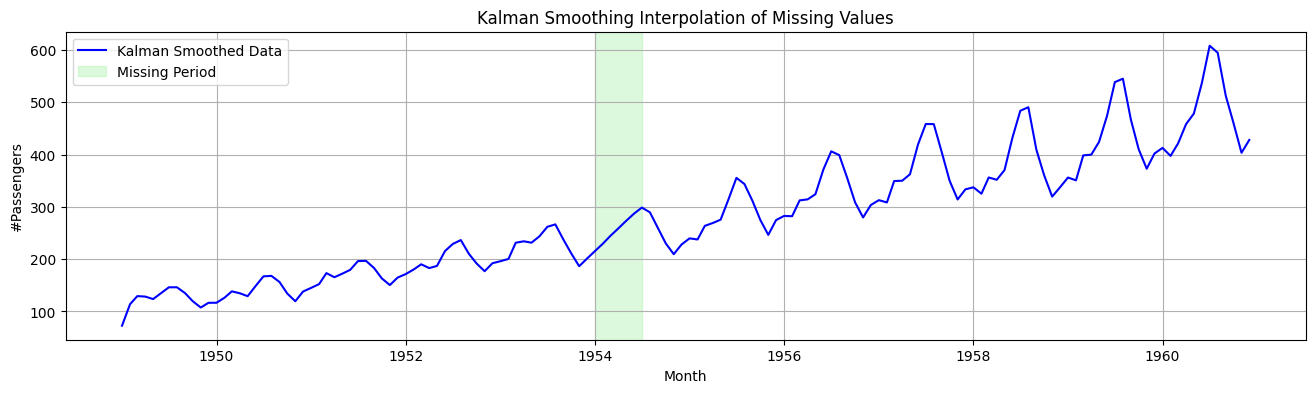

In [8]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np

# 一時的に線形補間で欠損値を埋める（初期値として使用）
# これによりpykalman の em メソッドがエラーを起こさずに処理を行える
data_filled = data.copy()
data_filled['#Passengers'] = data['#Passengers'].interpolate(method='linear')

# カルマンフィルタの初期化
kf = KalmanFilter(
    initial_state_mean=0,  # 初期状態の平均値
    n_dim_obs=1  # 観測値の次元
)

# カルマンフィルタのトレーニング（EMアルゴリズムでパラメータ推定）
kf = kf.em(data_filled['#Passengers'], n_iter=10)

# 平滑化処理（カルマン平滑化）
state_means, state_covariances = kf.smooth(data_filled['#Passengers'].values)

# 補間されたデータ
kalman_interpolated_data = data.copy()
kalman_interpolated_data['#Passengers'] = state_means[:, 0]

# プロット
plt.figure(figsize=(16, 4))
plt.plot(kalman_interpolated_data.index, kalman_interpolated_data['#Passengers'], label='Kalman Smoothed Data', color='blue')

# 欠損期間を色付け（例: 1954年1月から6月を色付け）
plt.axvspan(start_missing, end_missing, color='LightGreen', alpha=0.3, label='Missing Period')

# グラフの詳細設定
plt.title('Kalman Smoothing Interpolation of Missing Values')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.legend()
plt.grid(True)
plt.show()


## <font color="SeaGreen">1-b 定常性と非定常性</font>
<font color="red">時系列データを解析する上で特に重要なのが、時系列から非定常性を抽出することです。</font>
時系列データの解析は、非定常性との戦いです。<font color="red">時系列データからいかにして非定常性を取り除き、定常性を持つ時系列としてモデリングするかが肝になります。</font>残念なことに、実際に得られる時系列データのほとんどは非定常性を持ちます。さて、定常性、非定常性とはどう言った意味でしょうか。


**<u>定常性（Stationarity）</u>**とは、<br>
時系列データの期待値及び自己共分散が時間によらず一定である性質のことを指します。この性質は、時系列解析を行う上でしばしば重要な前提条件となります。

定常性には、以下の特徴があります：

- 平均が一定<br>
時間が経過してもデータの平均値が変化しないことを指します。言い換えれば、どの時点でもデータの中心が同じであるということです。

- 分散が一定<br>
時間によってデータのばらつき（散らばり具合）が変化しないことを意味します。つまり、どの時点でも分散が一定であるという性質です。

- 自己共分散が一定<br>
2つの異なる時点間の関連性（自己相関）が、具体的な時刻ではなく、2つの時点の時間差（ラグ）のみに依存することを示します。

定常性を持つデータは、平均や分散、相関などの特性が時間に依存せず一定であるため、時系列モデルを適用しやすく、予測の精度も安定します。この特性により、過去のデータに基づいて構築したモデルを将来の予測にも適用できる可能性が高くなります。定常性を満たしている場合、データの統計的性質が変わらないため、モデルがデータのパターンを正確に捉えやすいのです。

その結果、定常性を持つデータを基に作られたモデルは、予測や解析で高い信頼性を提供します。こうした理由から、**深層学習を含む多くの機械学習モデルは、データが定常であることを仮定しており、一般的に、非定常データではデータを定常化してから分析を行います。**

先程の飛行機乗客数データは明らかに非定常であり、このデータをそのまま機械学習モデルに入力しても優れた結果は得られないでしょう。

### 定常性の確認
時系列データが定常か非定常かを確認するためには、視覚的に確認する方法と統計的に確認する方法が一般的です。
統計的な確認方法として、**ADF検定（Augmented Dickey-Fuller Examination）**があります。基盤となる考えは、「データが単位根（unit root）を持つかどうか」を検定することです。単位根を持つデータは非定常とされ、単位根がない場合は定常と判断されます。
これは、時系列データの解析前に定常性を確認する基本的な手法であり、適切なモデル構築や予測精度向上に役立つ重要な方法です。

<u>簡単な仕組み</u><br>
- 帰無仮説（H<sub>0</sub>)：データは非定常（時間によって変化する）。<br>
意味：データが単位根を持つ場合、平均や分散が時間によって変化する可能性があり、データは非定常とみなされます。<br>
- 対立仮説（H<sub>1</sub>)：データは定常（時間によらず安定している）。<br>
意味：データが単位根を持たない場合、時間が進んでも平均や分散が変化せず、統計的性質が一定に保たれるとみなされます。<br>

<u>使い方と結果の見方</u><br>
ADF検定の結果から「p値」を確認します。<br>
- p値が0.05未満：データは定常性を持つと判断。<br>
- p値が0.05以上：データは非定常と判断。

<u>ADF検定の出力</u><br>
ADF検定を行うと、以下の情報が得られます。

- ADF統計量：データが単位根を持つかどうかを判断するための値。小さいほど定常性を示す。<br>
- p値（p-value）：帰無仮説を棄却できるかどうかを判断するための値。一般に、p < 0.05 の場合、帰無仮説を棄却し、データが定常であると判断します。<br>
- クリティカル値：検定統計量と比較するための閾値。1%、5%、10%の信頼水準が提示されます。<br>
- 検定結果の解釈：p-値が小さければ、データは定常性を持つと判断できます。





では、欠損値のないAir Passengers Datasetを読み込んでADF検定を行ってみます。

<ipython-input-9-b1daf814784f>:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',


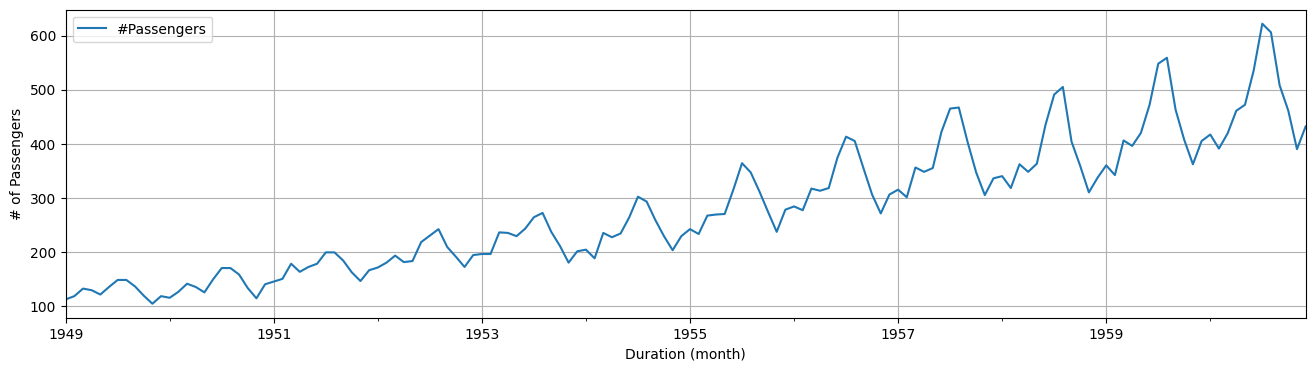

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime

# 欠損値を含まないAir Passengers Dataset読み込み
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',
                   index_col='Month',
                   date_parser=dateparse,
                   dtype='int')

# plot figure
data.plot(figsize=(16,4))
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
plt.grid(True)

In [10]:
# Augmented Dickey-Fuller Examination (ADF Examination)
from statsmodels.tsa.stattools import adfuller
res = adfuller(data)
print(f'p-val: {res[1]}')

p-val: 0.991880243437641


p-val > 0.5 であるので、帰無仮説が棄却されず、定常とは言えないので、非定常であるという前提で解析を行います （これは、必ず非定常であるという意味ではありません）。

### 対数変換
時系列データを解析する前に、非定常な時系列データに対する小さなテクニックを紹介します。それは対数変換と呼ばれるもので、指数関数的な上昇を伴うような非定常なデータに対して有効です。対数変換を行なったデータに対して予測を行い、指数関数で元に戻すと良い精度が得られる場合が多くあります。

Air Passengers Datasetに対して対数変換を行いプロットしてみます。

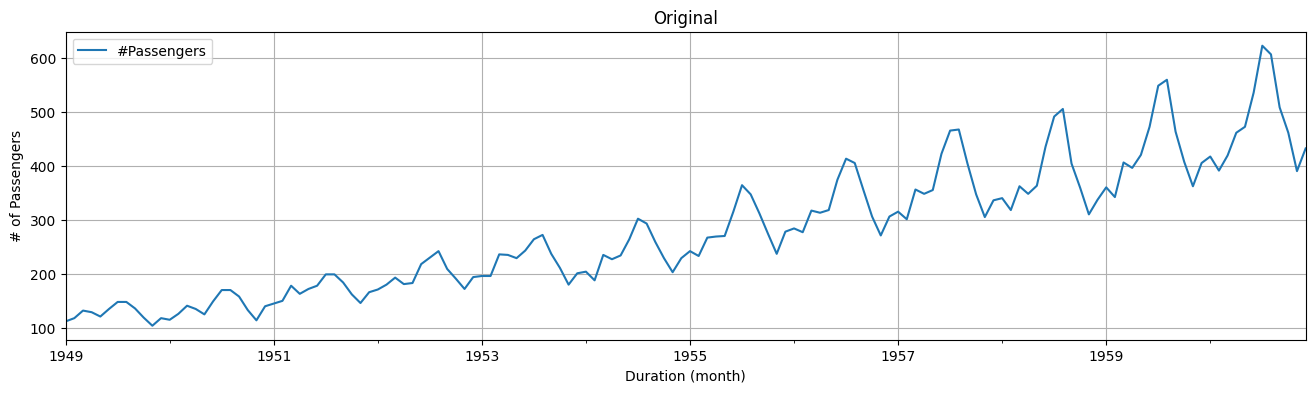

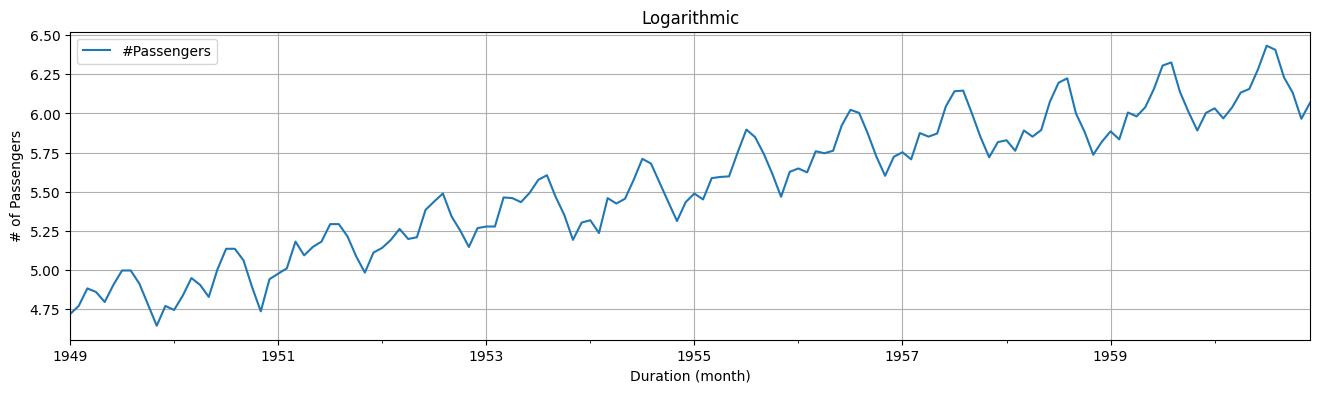

In [11]:
data_log = np.log(data)

# plot original data
data.plot(figsize=(16,4))
plt.title('Original')
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
plt.grid(True)

# plot log data
data_log.plot(figsize=(16,4))
plt.title('Logarithmic')
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
plt.grid(True)

上記のように、データの指数関数的な発散が落ち着いたグラフになります。<br>
ここで、対数変換したデータに対しADF検定を実施してみます。

In [12]:
res_log = adfuller(data_log)
print(f'p-val (original): {res[1]}')
print(f'p-val (logarithmic): {res_log[1]}')

p-val (original): 0.991880243437641
p-val (logarithmic): 0.4223667747703874


このように、帰無仮説は棄却され、データは定常であると言えます。
視覚的な分析だけでなく統計的な検定も行うことで、より確実な判断が可能となります。

## <font color="SeaGreen">1-c 時系列データからの特徴抽出</font>
では、時系列データからどのようにして非定常性を抽出すれば良いのでしょうか。時系列データの非定常性とは、大きく分けて (a) トレンド、(b) 季節性、(c) 残差の三つが挙げられます。すなわち、時系列データを  

* (加法モデル) $原系列O(t) = トレンドT(t) + 季節性S(t) + 残差I(t)$ または
* (乗法モデル) $原系列O(t) = トレンドT(t) * 季節性S(t) * 残差I(t)$

と表現し、それぞれの非定常成分をモデル化することにより原系列の予測を実現します。それぞれの非定常成分について、以下で実際に抽出してみましょう。

### <u>トレンドの抽出</u>
トレンドとは、さまざまな要因により徐々に増加したり減少するような傾向を指します。徐々にデータが上昇するということは、データの分布（単変量ガウス分布なら平均値と分散値）が変わるということなので、時系列データに非定常性を与えます。学習データとテストデータの間で分布が変わるため、データの定常性を仮定したモデルでは適切な予測ができません。 そこでまずは、時系列データからトレンドを抽出してみましょう。

具体的な方法は非常に簡単です。移動平均を取ることによって、または回帰直線を求めることによって簡単に時系列データのトレンドを確認することができます。ここでは単回帰直線を求めてみましょう。

trend:[0.01004838], trend rate: [0.00208747]


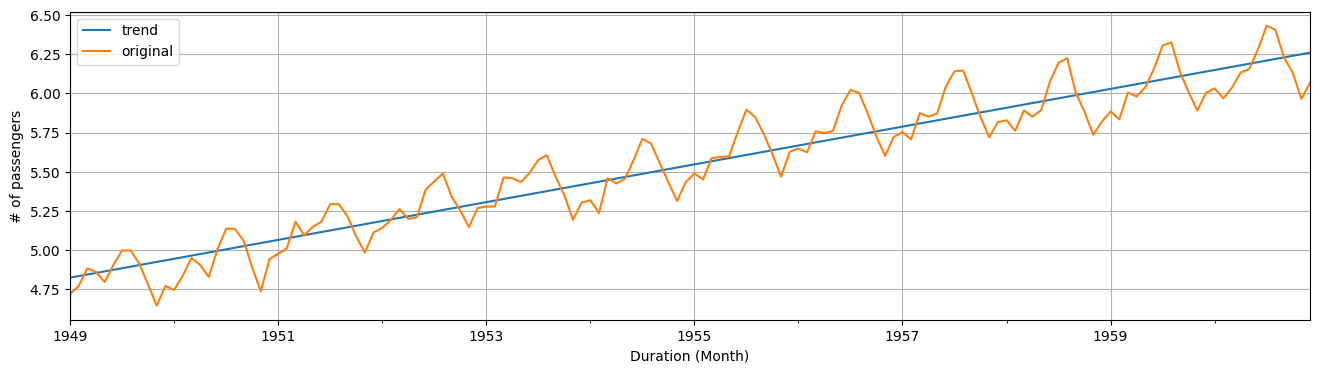

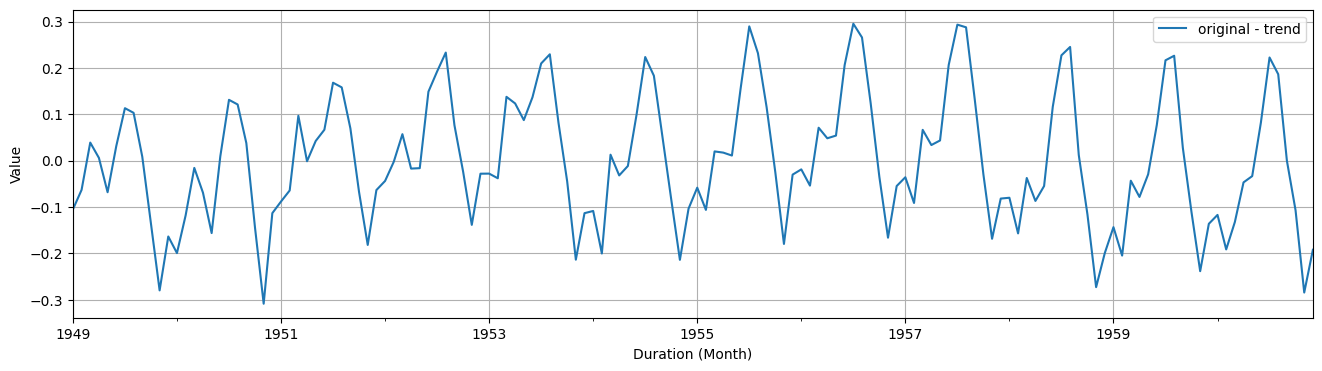

In [13]:
# get trend line
t = np.linspace(1, len(data_log), len(data_log))
a, b = np.polyfit(t, data_log, 1)
trend = pd.DataFrame(a*t + b, columns=['#Passengers'])
trend = pd.concat([pd.Series(data_log.index), trend], axis= 1)
trend = trend.set_index('Month')
print(f'trend:{a}, trend rate: {a/b}')

# plot result
ax = trend.plot(figsize=(16,4))
data_log.plot(ax=ax)
plt.legend(['trend', 'original'])
plt.xlabel('Duration (Month)')
plt.ylabel('# of passengers')
plt.grid(True)

# plot data - trend
notrend_data = data_log - trend
notrend_data.plot(figsize=(16,4))
plt.legend(['original - trend'])
plt.xlabel('Duration (Month)')
plt.ylabel('Value')
plt.grid(True)
plt.show()

もとのグラフからトレンドを除いたグラフとなりました。

### <u>季節性の抽出</u>
季節性とは、一週間や一年間ごとなどの、時系列データの周期的な振る舞いのことです。今回扱っている乗客数データは夏休みにピークがあり、明確な季節性を持ちます。そして、季節成分の周期期間の検出方法はいくつかありますが、今回はスペクトル分析によって抽出してみましょう。

#### スペクトル分析
- スペクトル分析とは<br>
信号やデータを周波数成分ごとに分解して、その分布や強さを調べる方法です。特に、信号がどの周波数でどれだけ強く振動しているかを「スペクトル（周波数の成分）」として可視化・解析します。
    - 音楽を分析すると、どの音の高さ（周波数）が含まれているかがわかります。
    - 地震波を調べると、どの振動が重要かを解析できます。
    - 画像処理では、画像の細かさ（周波数）を調べることで特徴を捉えます。

- フーリエ変換とは<br>
よく利用されるスペクトル分析の手法としてフーリエ変換があります。
今回は高速フーリエ変換 (FFT) を用いて季節性を抽出します。FFTは時系列データの時間領域を周波数領域に変換することで、周期的な振る舞いを抽出する代表的な手法です。

では、先ほどのトレンドを除去したデータに対して高速フーリエ変換を用いて季節性を抽出してみます。

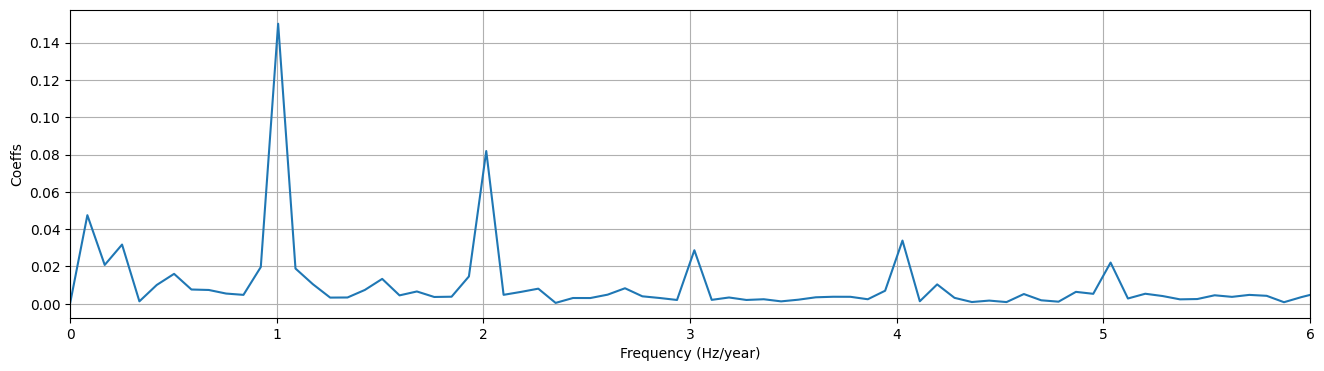

In [14]:
# remove trend
notrend_data = data_log - trend

# settings
N = len(notrend_data)
fs = 12 # month
dt = 1/fs # month
t = np.arange(0.0, N*dt, dt)
freq = np.linspace(0, fs, N)
fn=1/dt/2

# Fast Fourier Transform (FFT)
fft_data = np.fft.fft(notrend_data, axis=0)/(N/2)
amp = np.abs(fft_data)

# plot result
plt.figure(figsize=(16,4))
plt.plot(freq, amp)
plt.xlim(0,int(fs/2))
plt.xlabel('Frequency (Hz/year)')
plt.ylabel('Coeffs')
plt.grid(True)
plt.show()

1年ごとの周期性を美しく捉えています。フーリエ変換で得られる係数は、一般的に低周波成分ほど大きくなります。高周波成分にはノイズが乗っており、これを除去してみましょう。 除去したフーリエ変換後のデータを逆フーリエ変換 (IFFT) すると、以下のようなグラフが得られます。逆フーリエ変換は、周波数領域のデータを元の時間領域に戻します。

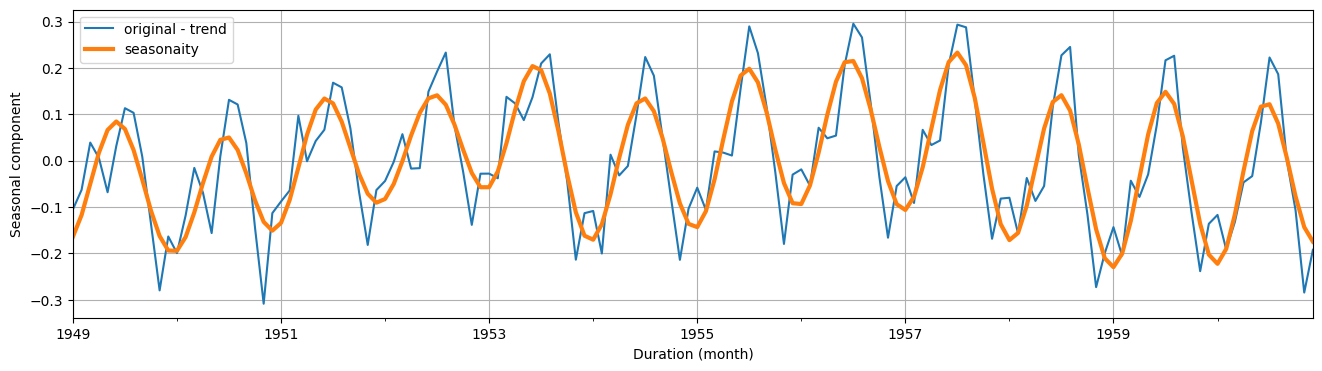

In [15]:
# remove noise (low-pass filter)
fft_data[(freq>1.5)] = 0

# Inverse Fast Fourier Transform (IFFT)
seasonality = pd.DataFrame(np.real(np.fft.ifft(fft_data, axis=0))*N,columns=['#Passengers'])
seasonality = pd.concat([pd.Series(data_log.index), seasonality], axis=1)
seasonality = seasonality.set_index('Month')

# plot figure
ax = notrend_data.plot(figsize=(16,4))
seasonality.plot(ax=ax, linewidth=3.0)
plt.xlabel('Duration (month)')
plt.ylabel('Seasonal component')
plt.legend(['original - trend', 'seasonaity'])
plt.grid(True)
plt.show()


美しい周期的な波形が現れました。

### <u>残差の抽出</u>
残るは残差です。残差は時系列データからトレンドや季節性を取り除いた後に残る不規則な変動のことです。


先程示したように、
* $原系列O(t) = トレンドT(t) + 季節性S(t) + 残差I(t)$
であるため、残差は次のように書き表せます:  
* $残差I(t) = 原系列O(t) - トレンドT(t) - 季節性S(t)$  

実際に残差を求めてみましょう。

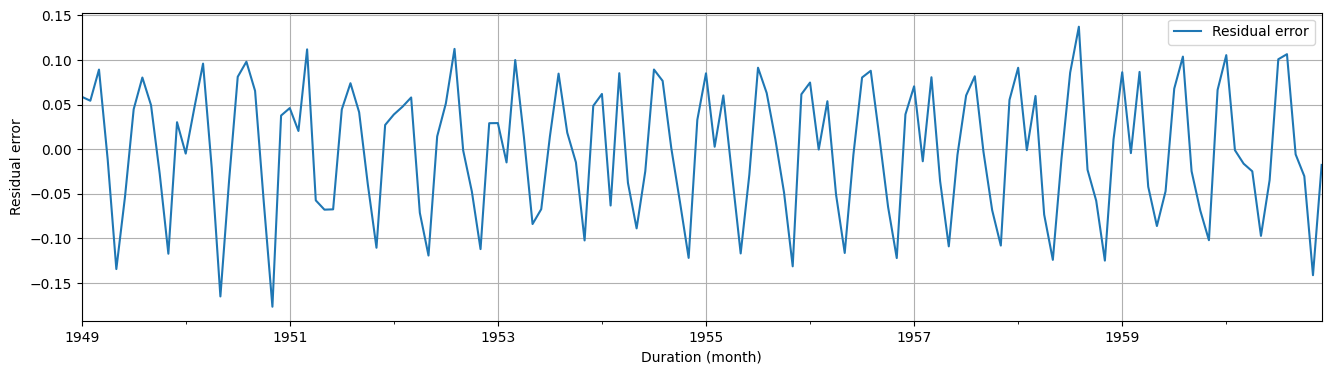

In [16]:
# compute residual error
resid = data_log - trend - seasonality

# plot result
resid.plot(figsize=(16,4))
plt.legend(['Residual error'])
plt.xlabel('Duration (month)')
plt.ylabel('Residual error')
plt.grid(True)
plt.show()

季節性を抽出する際に取り除いた高周波成分が残差に現れています。実際に時系列解析を行う際、残差が定常性を有するかどうかで、適切に時系列をモデリングできているか確認することがあります。もし残差が非定常で、トレンドや季節性を持つ場合、適切にモデリングできていない可能性があります。

ここでも、ADF検定を実施してみます。

In [17]:
res_resid = adfuller(resid)
print(f'p-val (original): {res_resid[1]}')

p-val (original): 1.6649234876441046e-22


非常に小さな値となり、残差は定常性を持つ可能性が高いようです。

### <u>可視化による定常性の確認</u>
さらに、定常性を検定するために、残差データのヒストグラムを作成してみます。
残差が平均0、標準偏差1の**正規分布**に従っていれば、定常的なホワイトノイズ とみなすことができます。これは、データに周期性やトレンドがなく、ランダムな変動だけが残っている ことを意味します。
もし正規分布から大きく外れる場合は、データにトレンドや周期性が残っている可能性があり、さらなる処理が必要となります。

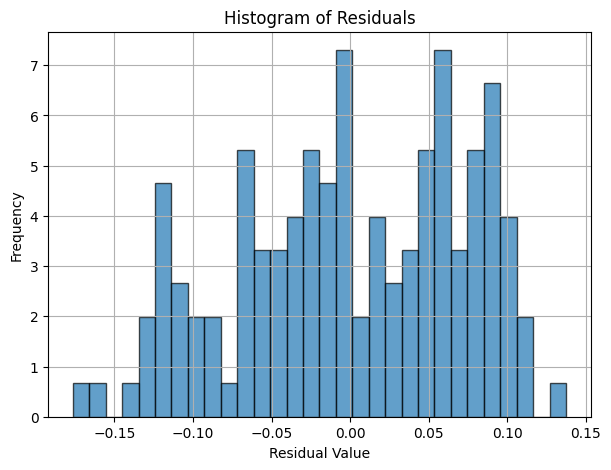

In [18]:
# 残差データのヒストグラムをプロット
plt.figure(figsize=(7, 5))
plt.hist(resid, bins=30, edgecolor='black', alpha=0.7, density=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


完全ではありませんが、およそ正規分布に近い形となり定常性を持っていそうです。

### API statsmodelsを利用
丁寧に全て実装して説明してきましたが、実際に時系列を取り扱う時は便利なツールが用意されており、たった1行で時系列データを (a) トレンド、(b) 季節性、 (c) 残差に分解することができます。自力で分解するより綺麗ですね。今回は目視でわかりやすいように、残差以外の成分を正規化して表示しています。

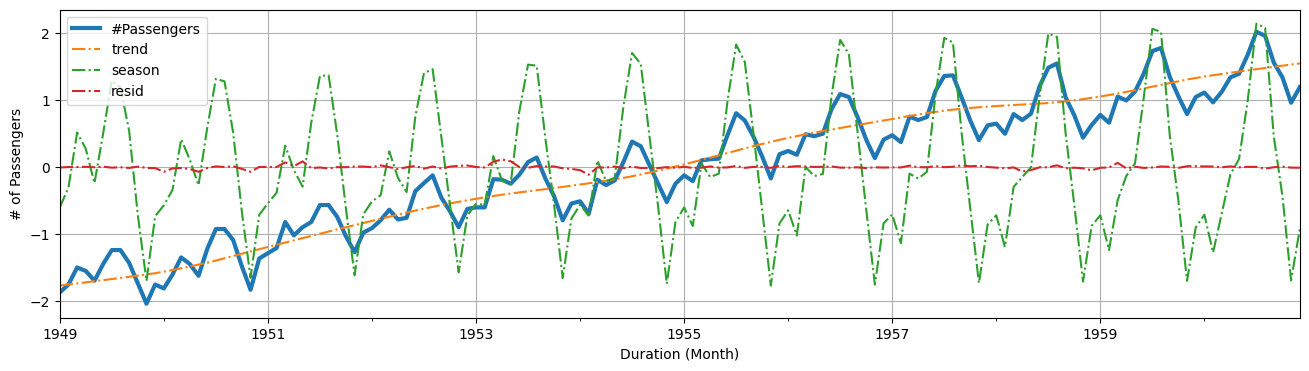

In [19]:
# Seasonal Decomposition Of Time Series By Loess (STL decomposition)
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore

# decomposition
stl=STL(data_log, robust=True)
stl_series = stl.fit()

# plot
zscore(stl_series.observed).plot(figsize=(16,4), linewidth=3.0)
zscore(stl_series.trend).plot(linestyle='dashdot')
zscore(stl_series.seasonal).plot(linestyle='dashdot')
stl_series.resid.plot(linestyle='dashdot')
plt.xlabel('Duration (Month)')
plt.ylabel('# of Passengers')
plt.legend()
plt.grid(True)
plt.show()

## <font color="SeaGreen">1-d 時系列データの平滑化</font>
時系列データはノイズを含むことが多く、パターンを明確にするために平滑化が必要になることがあります。ここでは平滑かの手法として階差と移動平均について解説します。

### **階差による平滑化**
階差とはとてもシンプルで、元データからある時刻離れた点のデータと元データの差のことです。元データを階差系列に変換することで、トレンドの除去を行い、予測しやすい定常過程に変換するために用いられることがあります。

階差系列は次のように計算されます：<br>
1階差分：
$$
\Delta Y_t = Y_t - Y_{t-1}
$$

2階差分：
$$
\Delta^2 Y_t = \Delta Y_t - \Delta Y_{t-1} = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})
$$

階差を複数回取ることで、高次のトレンドや非定常性を取り除くことが可能です。

#### なぜ階差を取ると定常性に近づくのか？

例）線形トレンドのあるデータの場合
データが次のような線形トレンドを持つとします。
$$
Y_t = a t + \epsilon_t
$$

ここで、 $at$はトレンド、$\epsilon_t$はランダムノイズ。<br>
1階差分を取ると：
$$
\Delta Y_t = Y_t - Y_{t-1} = a(t - (t - 1)) + (\epsilon_t - \epsilon_{t-1}) = a + (\epsilon_t - \epsilon_{t-1})
$$

これにより、トレンド成分$at$が取り除かれ、定常性に近づきます。

<font color="red">特に、指数的な成長を伴うデータでは、ログ変換と差分の組み合わせが有効です。</font>

実際に階差系列を見てみましょう。
まずは対数変換したデータに対して1階差を取ります。階差系列（次数1）とは、1期前のデータとの差分を計算し求めた時系列データです。



In [20]:
# compute difference
data_diff_1 = data_log.diff(periods=1)
combined_df = pd.concat([data_log, data_diff_1], axis=1)
# set columns name
combined_df.columns = ["data_log", "data_diff_1"]
combined_df

,data_log,data_diff_1
Month,,
1949-01-01,4.718499,NaN
1949-02-01,4.770685,0.052186
1949-03-01,4.882802,0.112117
1949-04-01,4.859812,-0.022990
1949-05-01,4.795791,-0.064022
...,...,...
1960-08-01,6.406880,-0.026060
1960-09-01,6.230481,-0.176399
1960-10-01,6.133398,-0.097083


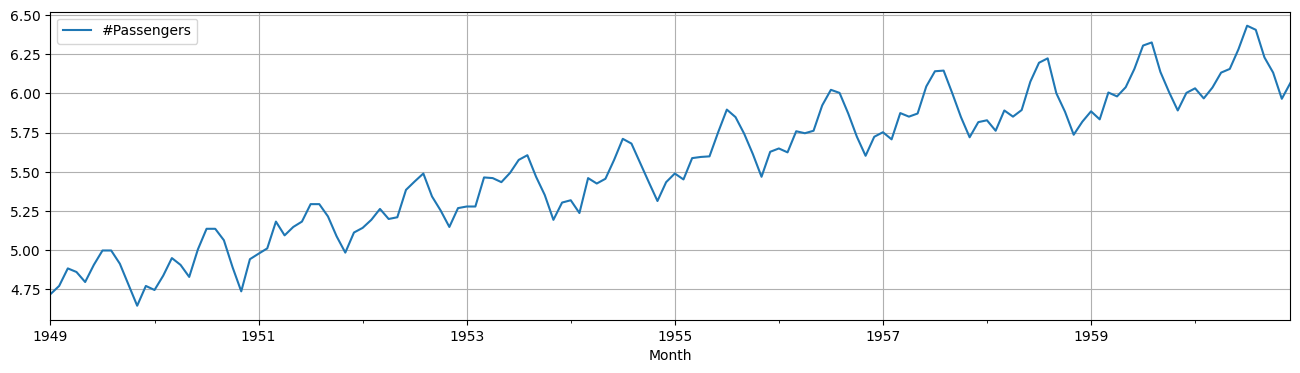

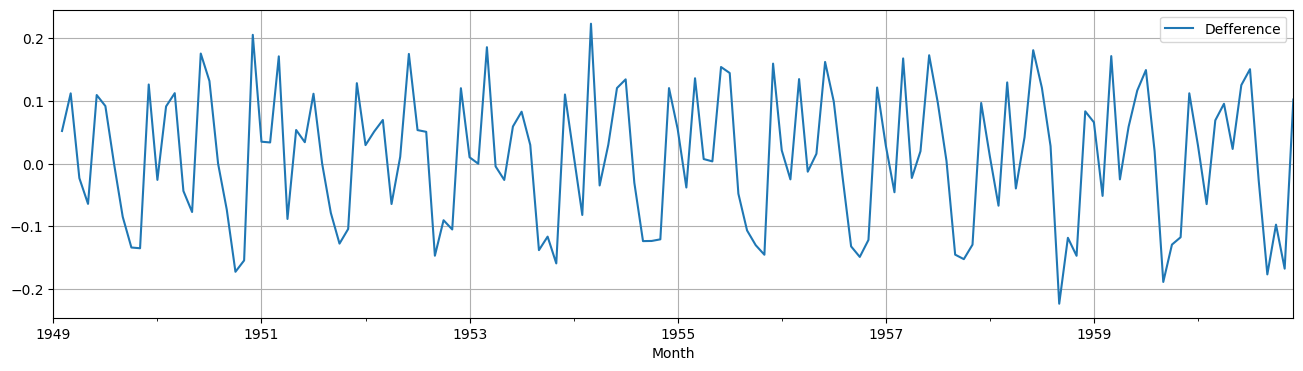

In [21]:
# plot figure
data_log.plot(figsize=(16,4))
plt.grid(True)
data_diff_1.plot(figsize=(16,4))
plt.legend(['Defference'])
plt.grid(True)

周期性は残ってしまいますが、上昇トレンドを階差として抽出でき、定常に近い波形に変換されました。
おそらく年単位で周期があるのではないかという想像ができるので、試しに12ヶ月での階差を取るとどうなるか確認してみましょう。

In [22]:
# compute difference
data_diff_12 = data_log.diff(periods=12)
combined_df = pd.concat([data_log, data_diff_12], axis=1)
# set columns name
combined_df.columns = ["data_log", "data_diff_12"]
combined_df.head(15)

,data_log,data_diff_12
Month,,
1949-01-01,4.718499,NaN
1949-02-01,4.770685,NaN
1949-03-01,4.882802,NaN
1949-04-01,4.859812,NaN
1949-05-01,4.795791,NaN
1949-06-01,4.905275,NaN
1949-07-01,4.997212,NaN
1949-08-01,4.997212,NaN
1949-09-01,4.912655,NaN


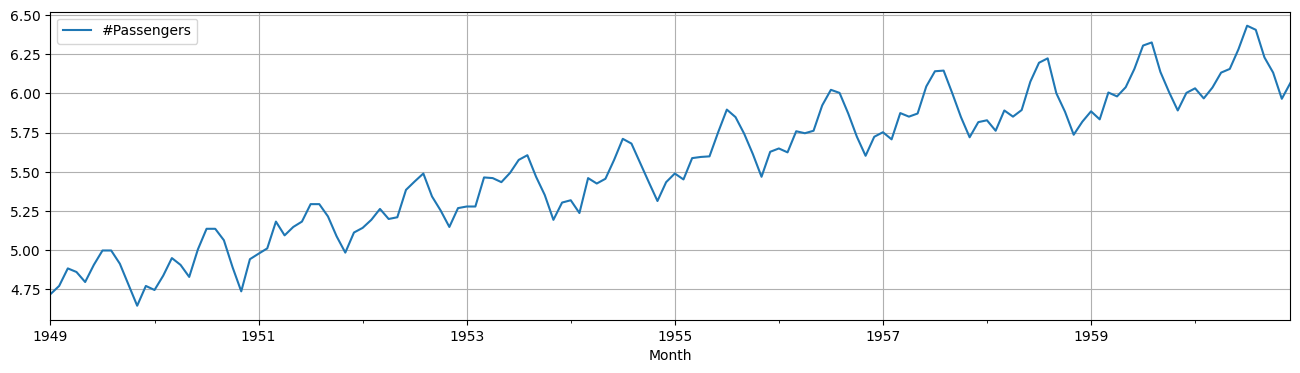

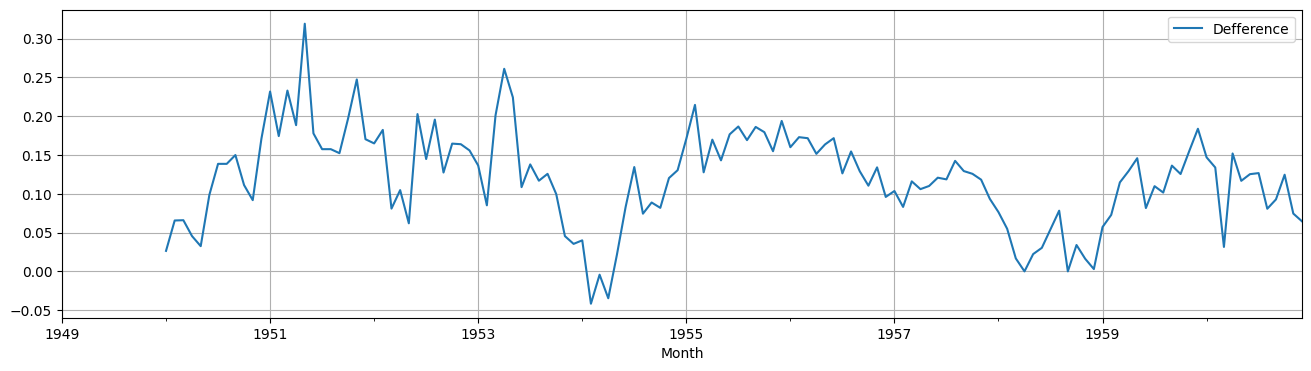

In [23]:
# plot figure
data_log.plot(figsize=(16,4))
plt.grid(True)
data_diff_12.plot(figsize=(16,4))
plt.legend(['Defference'])
plt.grid(True)

周期性は消えたように見えます。
この12ヶ月の階差を取ったものに対してさらに1階差取ってみます。

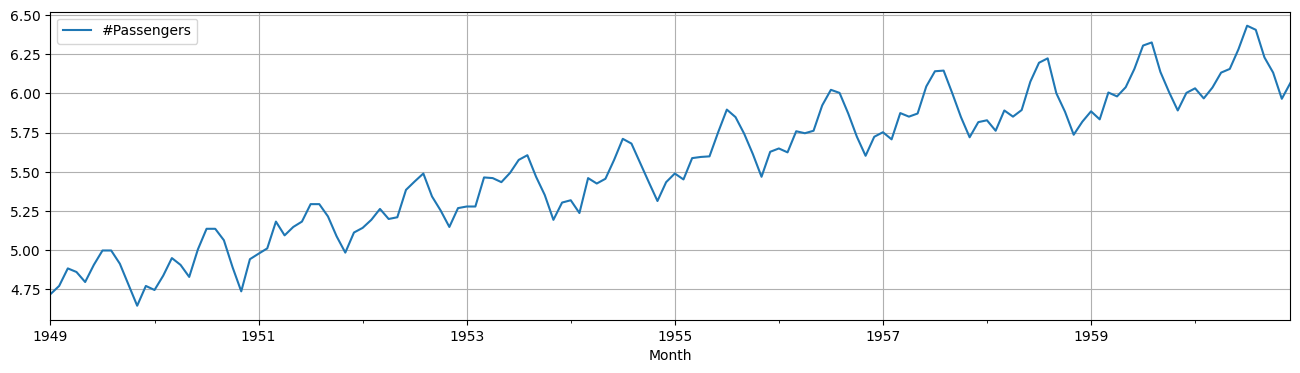

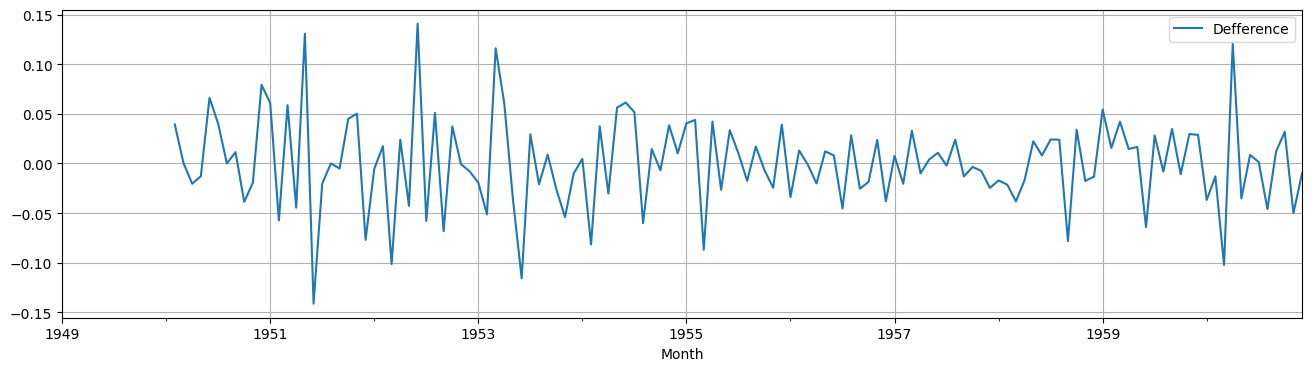

In [24]:
# compute difference
data_diff_12_1 = data_diff_12.diff(periods=1)

# plot figure
data_log.plot(figsize=(16,4))
plt.grid(True)
data_diff_12_1.plot(figsize=(16,4))
plt.legend(['Defference'])
plt.grid(True)

平均はおおよそ0に収束しており、分散についても初めはやや大きい部分が見られるものの、特に問題はなさそうです。また、周期性も徐々に消失してきたように思われます。

このように原系列が非定常であり、その差分系列が定常であるような時系列データを**単位根過程**といいます。

データによってどのような処理をするかは変わってきますが、階差を取ることによって時系列データを定常に近づけることができることがお分かりいただけましたでしょうか。

### **移動平均による平滑化**
時系列データの平滑化は、<font color="red">ノイズを減らすことでトレンドを明確にする</font>ために有効な手法です。

#### 移動平均とは
時系列データの短期的な変動を滑らかにして、全体の傾向（トレンド）を見やすくする方法 です。データが細かく上下に動いている場合、その変動を平滑化することで、全体の流れを理解しやすくなります。

移動平均は、一定期間のデータの平均値を順番に計算し、その平均値をつないでいく方法 です。<br>
例えば、以下のデータで3日の移動平均を計算する場合：

| **日付** | **データ（売上）** | **3日の移動平均（SMA）** |
| :---: | :---: | :---: |
| 1月1日 | 10万円 | （データ不足） |
| 1月2日 | 12万円 | （データ不足） |
| 1月3日 | 14万円 | (10 + 12 + 14) ÷ 3 = 12万円 |
| 1月4日 | 15万円 | (12 + 14 + 15) ÷ 3 = 13.67万円 |
| 1月5日 | 16万円 | (14 + 15 + 16) ÷ 3 = 15万円 |

このように、ウィンドウ（計算する範囲）を1日ずつ移動させながら平均を計算するため、「移動平均」と呼ばれます。

- ウィンドウサイズ とは<br>
移動平均を計算する際に使うデータの期間（幅）のことです。
ウィンドウサイズが3日の場合、直近3日分のデータの平均を計算することを意味します。

- ウィンドウサイズの違いと効果<br>
    - 小さいウィンドウサイズ（短期間）
    データの細かい変動に敏感 → 短期的な変動をすぐに捉えられるがノイズも多く残るため、グラフがギザギザになりやすい
    - 大きいウィンドウサイズ（長期間）
    短期的な変動を平滑化し長期的な傾向（トレンド）を把握しやすいが、データの急激な変化には反応が遅くなる

    <font color="red">ウィンドウサイズ を調整することで、短期的な変動に着目するか、長期的な傾向を見るかをコントロールできます。</font>


#### 単純移動平均（SMA）
単純移動平均 (Simple Moving Average, SMA) は、一定の期間のデータの平均を計算し、それを時系列データ上で移動させることでトレンドを滑らかにする手法です。<br>
以下のデータは1秒ごとの温度変化を捉えたセンサデータです。<br>
窓幅（window）を 7 と 30 で移動平均(SMA)を計算し、オリジナルデータとともにプロットします。

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# データの読み込み
sensor_data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/sensor_data.csv')

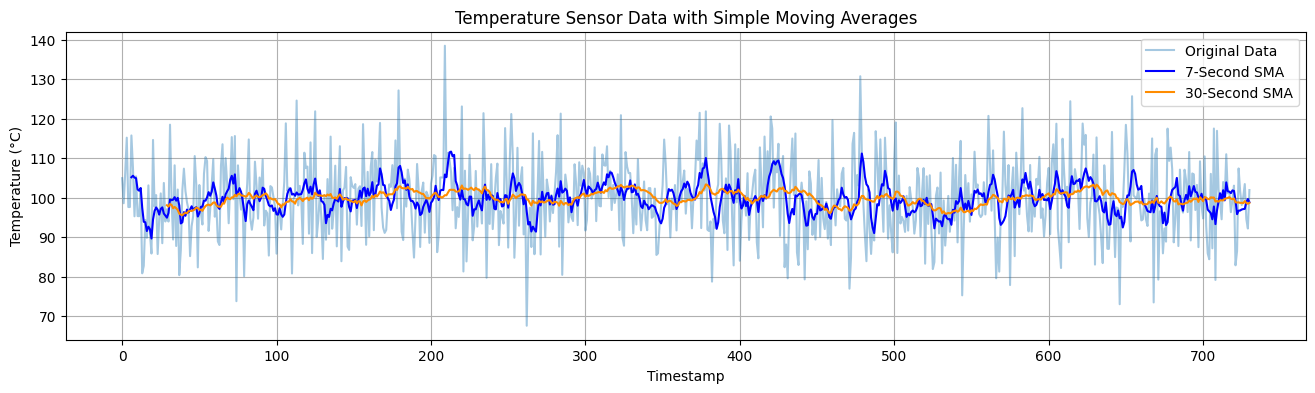

In [27]:
# 移動平均の計算（7秒と30秒のウィンドウサイズを指定）
sensor_data['SMA_7'] = sensor_data['Temperature'].rolling(window=7).mean()
sensor_data['SMA_30'] = sensor_data['Temperature'].rolling(window=30).mean()

# グラフ描画
plt.figure(figsize=(16, 4))
plt.plot(sensor_data['Temperature'], label='Original Data', alpha=0.4)
plt.plot(sensor_data['SMA_7'], label='7-Second SMA', color='blue')
plt.plot(sensor_data['SMA_30'], label='30-Second SMA', color='darkorange')
plt.title('Temperature Sensor Data with Simple Moving Averages')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

#### 指数移動平均（EMA）
指数移動平均 (Exponential Moving Average, EMA) は、直近のデータにより大きな重みを与える移動平均です。これは、過去のデータよりも最近のデータの影響を強く反映する特徴があります。

同じセンサーデータを用いて、窓幅（window）を 7 と 30 で指数移動平均(EMA)を計算し、オリジナルデータとともにプロットします。

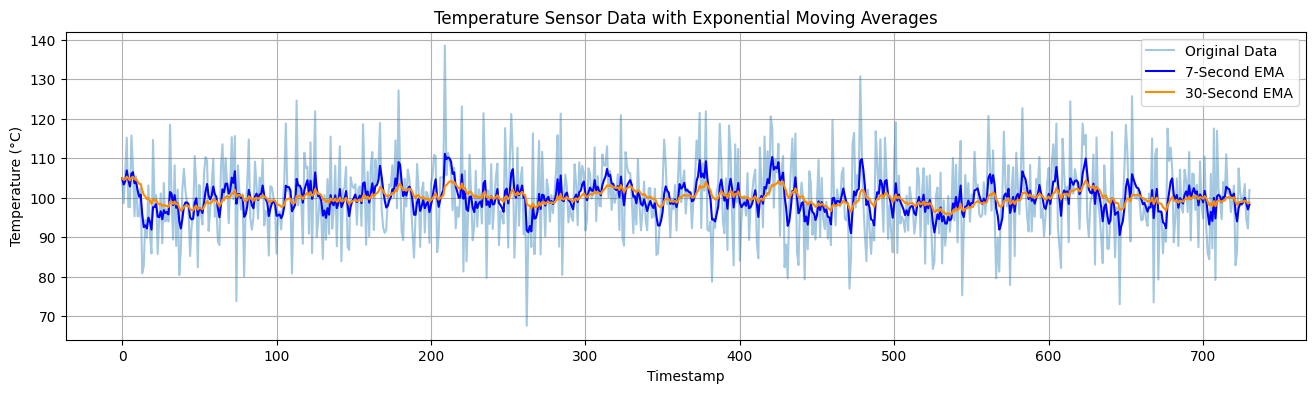

In [28]:
# EMA（指数移動平均）の計算（7秒と30秒のウィンドウサイズを指定）
sensor_data['EMA_7'] = sensor_data['Temperature'].ewm(span=7, adjust=False).mean()
sensor_data['EMA_30'] = sensor_data['Temperature'].ewm(span=30, adjust=False).mean()

# グラフ描画
plt.figure(figsize=(16, 4))
plt.plot(sensor_data['Temperature'], label='Original Data', alpha=0.4)
plt.plot(sensor_data['EMA_7'], label='7-Second EMA', color='blue')
plt.plot(sensor_data['EMA_30'], label='30-Second EMA', color='darkorange')
plt.title('Temperature Sensor Data with Exponential Moving Averages')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

移動平均を適用するメリットとしては、

- データのノイズを除去し、傾向（トレンド）を明確にする
- 予測や異常検知の際に、短期的な変動に惑わされにくくする
- SMA は長期的なトレンドを捉えやすく、EMA は短期的な変化を素早く捉えられる

これらの手法を適切に使い分けることで、時系列データの解析や予測に役立てることができます。

## <font color="SeaGreen">まとめ</font>
データにはさまざまな周期的なパターンが含まれているため、<font color="red">1つの周期性を取り除くだけでは十分ではありません。</font>

データに含まれる周期性の例としては、以下のようなものが存在します。
- 週ごとの周期性（週単位で変動するパターン）
- 月ごとの周期性（月末に売上が増えるなどの傾向）
- 年ごとの周期性（クリスマスやお正月などの影響）
- 4年に1回のイベント（オリンピックやうるう年の影響）

<font color="red">実務では、これら複数の周期性を適切に考慮し、分析や予測に反映させることが重要です。</font><br>周期性を正しく処理しなければ誤った分析結果や予測を導いてしまう可能性があることを意識しましょう。